## Imports

In [1]:
# necessary imports
import random
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models #gpu
# import # macro f1 score - https://bestkcs1234.tistory.com/61

# import albumentations as A
# https://albumentations.ai/docs/examples/tensorflow-example/
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## Hyperparameter Setting

In [2]:
CFG = {
    'FPS' : 30,
    'IMG_SIZE': 128,
    'EPOCHS': 10,
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 4,
    'SEED': 41
}

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # SEED 고정
    

## Data Load

In [4]:
train = pd.read_csv('./data/train.csv')

In [5]:
train.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [6]:
train['label'].value_counts()

3    133
1    129
2    121
4    114
0    113
Name: label, dtype: int64

### train 데이터 label 분포

In [7]:
train['label'].value_counts().values

array([133, 129, 121, 114, 113])

([<matplotlib.patches.Wedge at 0x2d24e2340>,
 [Text(0.8518816777434608, 0.6959149424498562, '3'),
  Text(-0.49180322740623394, 0.9839357628995972, '1'),
  Text(-1.0821777337152425, -0.1972089061146626, '2'),
  Text(-0.1972087541334739, -1.082177761411277, '4'),
  Text(0.9189213344776592, -0.6046350808891245, '0')],
 [Text(0.46466273331461494, 0.3795899686090124, '21.8%'),
  Text(-0.26825630585794574, 0.5366922343088711, '21.1%'),
  Text(-0.5902787638446777, -0.10756849424436142, '19.8%'),
  Text(-0.10756841134553122, -0.5902787789516056, '18.7%'),
  Text(0.5012298188059958, -0.3298009532122497, '18.5%')])

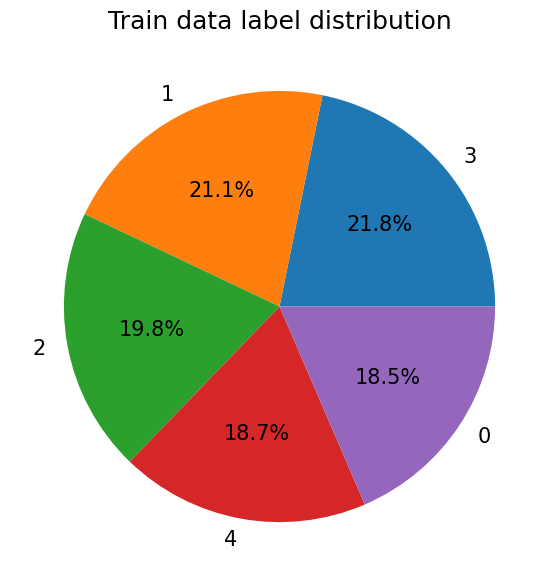

In [8]:
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['3', '1', '2', '4', '0'] # 타깃값 레이블
plt.title('Train data label distribution')
plt.pie(train['label'].value_counts().values, labels=label, autopct='%.1f%%')


In [9]:
test = pd.read_csv('./data/test.csv')

In [10]:
test.head()

,id,path
0,TEST_000,./test/TEST_000.mp4
1,TEST_001,./test/TEST_001.mp4
2,TEST_002,./test/TEST_002.mp4
3,TEST_003,./test/TEST_003.mp4
4,TEST_004,./test/TEST_004.mp4


## Train/ Validation Split

In [11]:
_, val, _, _ = train_test_split(train, train['label'], test_size=0.2, stratify=train['label'], random_state=CFG['SEED'])

In [12]:
val.shape

(122, 3)

## CustomDataset

In [15]:
train.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [13]:
file_path = './data/train/' + train.loc[0]['id'] + '.mp4'
file_path

'./data/train/TRAIN_000.mp4'

[ WARN:0@21.341] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@21.341] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@21.341] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@21.341] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664

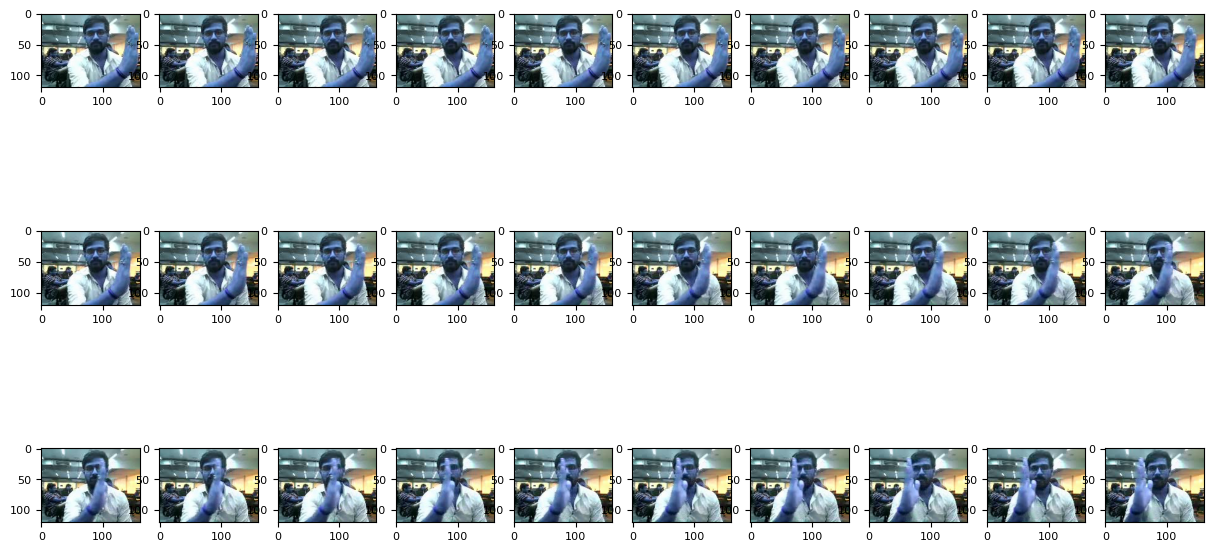

In [14]:
import matplotlib.gridspec as gridspec

mpl.rc('font', size=8)
plt.figure(figsize=(15,  8))
grid = gridspec.GridSpec(3, 10)

# 1초에 30프레임

frames = []
cap = cv2.VideoCapture(file_path) # 영상 불러오기 30프레임 리턴됨.
for i in range(CFG['FPS']): # 프레임 단위로 짤라서 반복문안에서 처리
    _, img = cap.read()# 30프레임중에 한개씩
    ax = plt.subplot(grid[i])
    ax.imshow(img)
    img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE'])) # img 리사이징
    img = img / 255. # 픽셀값 정규화 RGB 별로 각각 0~255 사이의 값을 가지는 픽셀값의 array들을 0~1 사이값으로 정규화
    frames.append(img)

In [16]:
frames[1].shape

(128, 128, 3)

In [17]:
np.array(frames).shape

(30, 128, 128, 3)

In [18]:
train.head()

,id,path,label
0,TRAIN_000,./train/TRAIN_000.mp4,3
1,TRAIN_001,./train/TRAIN_001.mp4,0
2,TRAIN_002,./train/TRAIN_002.mp4,1
3,TRAIN_003,./train/TRAIN_003.mp4,4
4,TRAIN_004,./train/TRAIN_004.mp4,4


In [19]:
val.reset_index(inplace=True)
val.drop('index', axis=1, inplace=True)
val.head()

,id,path,label
0,TRAIN_445,./train/TRAIN_445.mp4,0
1,TRAIN_209,./train/TRAIN_209.mp4,3
2,TRAIN_456,./train/TRAIN_456.mp4,4
3,TRAIN_382,./train/TRAIN_382.mp4,3
4,TRAIN_212,./train/TRAIN_212.mp4,0


In [ ]:
frames_train = []
train_label = []
frames_val = []
val_label = []

for i in tqdm(range(len(train))):
    file_name = train.loc[i,'id']
    label = train.loc[i, 'label']
    file_path = f'./data/train/{file_name}.mp4'
    cap = cv2.VideoCapture(file_path)
    for _ in range(CFG['FPS']):
        _, img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        frames_train.append(img)
        train_label.append(label)


for i in tqdm(range(len(val))):
    file_name = val.loc[i, 'id']
    label = val.loc[i, 'label']
    file_path = f'./data/train/{file_name}.mp4'
    cap = cv2.VideoCapture(file_path)
    for _ in range(CFG['FPS']):
        _, img = cap.read()
        img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
        img = img / 255.
        frames_val.append(img)
        val_label.append(label)

In [ ]:
np.array(frames_train).shape, np.array(frames_val).shape

In [ ]:
# train, val set
frames_train = np.array(frames_train)
frames_val = np.array(frames_val)
train_label = np.array(train_label)
val_label = np.array(val_label)

In [ ]:
frames_train.dtype

In [ ]:
train_label.dtype

In [ ]:
val['label'].values

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(frames_train, train_label, epochs=10, batch_size=4, validation_data=(frames_val, val_label))


In [ ]:
test.head()

In [ ]:
frames_test = []

file_path = f'./data/test/TEST_000.mp4'
cap = cv2.VideoCapture(file_path)
for _ in range(CFG['FPS']):
    _, img = cap.read()
    img = cv2.resize(img, (CFG['IMG_SIZE'], CFG['IMG_SIZE']))
    img = img / 255.
    frames_test.append(img)

In [ ]:
pred = model.predict(np.array(frames_test))

In [ ]:
pred